In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import sys

$\textbf{Finite-Difference Derivative Approximation}$

This can be done via two different approximation formulas:
- Forward-Difference
$$\frac{\partial f}{\partial x_i}(x) \approx \frac{f(x + \epsilon e_i) - f(x)}{\epsilon}$$
- Central-Difference
$$\frac{\partial f}{\partial x_i}(x) \approx \frac{f(x + \epsilon e_i) - f(x - \epsilon e_i)}{2\epsilon}$$

Where $\epsilon e_i$ represents a small change in the value of a single component of x (the i-th component).  
In a function $f: \mathbb{R} \rightarrow \mathbb{R}$ $e$ is just 1 and thus we represent a small shift in the value of x. In theory we should choose $\epsilon$ as small as possible but there is the problem with floating-point arithmetic. The book thus recommends the value $\epsilon = \sqrt{u}$, where u is the quantity known as unit roundoff.

In [4]:
# Accessing the unit roundoff value
u_sys = sys.float_info.epsilon
epsilon_sys = np.sqrt(u_sys)
print("Unit roundoff value (u_sys) from the sys package:", u_sys)
print("Epsilon from sys package u:", epsilon_sys)
print("\n")

# Calculate the unit roundoff value manually
u = 1.0
while 1.0 + u != 1.0:
    u /= 2
epsilon = np.sqrt(u)
    
# Print the unit roundoff value
print("Manually calculated unit roundoff value (u):", u)
print("Epsilon from manually calculated u:", epsilon)

Unit roundoff value (u_sys) from the sys package: 2.220446049250313e-16
Epsilon from sys package u: 1.4901161193847656e-08


Manually calculated unit roundoff value (u): 1.1102230246251565e-16
Epsilon from manually calculated u: 1.0536712127723509e-08


$\textbf{Small Notes:}$  
- When approximating the gradient via the central-difference method one can use $\epsilon = u^{1/3}$ to gain a few extra digits of accuray, 
  reducing the error from $O \left(\epsilon^2\right)$ to $O \left(u^{2/3}\right)$.
- The value from the Sys-package seems to be twice the value from the manually calculated unit roundoff. The difference is neglectable as the numbers are so incredibly small but I will still be going with the latter because it is exactly the number mentioned in the book.

In [6]:
central_epsilon = u**(1/3)
print(f"Epsilon for central-difference Method: {central_epsilon}")

Epsilon for central-difference Method: 4.806217383937355e-06


In [7]:
def forward_difference(func: callable, x: np.ndarray, epsilon: float) -> np.ndarray:
    """
    Parameters:
    func: Function you want to approximate the derivative of
    x: Point where at which you want the approximation of the derivative
    epsilon: very small number typically sqrt(u), where u is unit-roundoff
    Returns:
    Approximation of derivative at point x
    """
    dim = x.shape[0] if x.shape != () else 1
    grad = np.zeros(dim)
    
    for i in range(dim):
        e = np.zeros(dim)
        e[i] = 1
        grad_i = (func(x + epsilon * e) - func(x)) / epsilon
        grad[i] = grad_i
    
    return grad

def central_difference(func: callable, x: np.ndarray, epsilon: float) -> np.ndarray:
    """
    Parameters:
    func: Function you want to approximate the derivative of
    x: Point where at which you want the approximation of the derivative
    epsilon: very small number typically sqrt(u), where u is unit-roundoff
    Returns:
    Approximation of derivative at point x
    """
    dim = x.shape[0] if x.shape != () else 1
    grad = np.zeros(dim)
    
    for i in range(dim):
        e = np.zeros(dim)
        e[i] = 1
        grad_i = (func(x + epsilon * e) - func(x - epsilon * e)) / (2 * epsilon)
        grad[i] = grad_i
    
    return grad

$\textbf{Finite-Difference Hessian Approximation}$

There are some different approximation formulas for different use cases:
- General Approximation of Hessian (book formula):

$$\frac{\partial^2 f}{\partial x_i \partial x_j}(x) \approx \frac{f(x + \epsilon e_i + \epsilon e_j) - f(x + \epsilon e_i) - f(x + \epsilon e_j) + f(x)}{\epsilon^2}$$

- General Approximation of Hessian (Wikipedia formula):

$$\frac{\partial^2 f}{\partial x_i \partial x_j}(x) \approx \frac{f(x + \epsilon*(e_i + e_j)) - f(x + \epsilon*(e_i - e_j)) - f(x + \epsilon*(-e_i + e_j)) + f(x + \epsilon*(-e_i - e_j))}{4\epsilon^2}$$

- Hessian-vector product for some given vector p:  
  - This is used for example in the Newton CG method as they don't need the full Hessian but only the mentioned vector-matrix product.
  - The approximation has an approximation error of $O (\epsilon)$, but I assume thats higher if you take the approximated gradient instead of the original one.
  - The formula below is an based on the forward-difference method, there is also one for the central-difference method which is not provided by the book.
  - Not implemented.

$$\nabla^2 f(x)p \approx \frac{\nabla f(x + \epsilon p) - \nabla f(x)}{\epsilon}$$

In [9]:
def hessian_approximation_book(func: callable, x: np.ndarray, epsilon: float) -> np.ndarray:
    """
    Parameters:
    func: Function you want to approximate the derivative of
    x: Point where at which you want the approximation of the derivative
    epsilon: CAREFUL WITH CHOISE OF EPSILON!!!
             Using the above define u results in very bad results, best results after testing with 1e-4
    Returns:
    Approximation of hessian at point x
    """
    dim = x.shape[0] if x.shape != () else 1
    hessian = np.zeros((dim, dim))
    
    # diag elements
    for i in range(dim):
        e_i = np.zeros(dim)
        e_i[i] = 1
        term1 = func(x + 2 * epsilon * e_i)
        term2 = 2 * func(x + epsilon * e_i)
        term3 = func(x)
        hessian[i, i] = (term1 - term2 + term3) / (epsilon**2)
    
    # off-diag elements
    for i in range(dim):
        e_i = np.zeros(dim)
        e_i[i] = 1
        for j in range(i+1, dim):
            e_j = np.zeros(dim)
            e_j[j] = 1
            term1 = func(x + epsilon * (e_i + e_j))
            term2 = func(x + epsilon * e_i)
            term3 = func(x + epsilon * e_j)
            term4 = func(x)
            hessian[i, j] = hessian[j, i] = (term1 - term2 - term3 + term4) / (epsilon**2)
        
    return hessian

In [10]:
def hessian_approximation_wiki(func: callable, x: np.ndarray, epsilon: float) -> np.ndarray:
    """
    Parameters:
    func: Function you want to approximate the derivative of
    x: Point where at which you want the approximation of the derivative
    epsilon: CAREFUL WITH CHOISE OF EPSILON!!!
             Using the above define u results in very bad results, best results after testing with 1e-4
    Returns:
    Approximation of hessian at point x
    """
    dim = x.shape[0] if x.shape != () else 1
    hessian = np.zeros((dim, dim))
    
    # diag elements
    for i in range(dim):
        e_i = np.zeros(dim)
        e_i[i] = 1
        term1 = func(x + epsilon * e_i)
        term2 = 2 * func(x)
        term3 = func(x - epsilon * e_i)
        hessian[i, i] = (term1 - term2 + term3) / (epsilon**2)
    
    # off-diag elements
    for i in range(dim):
        e_i = np.zeros(dim)
        e_i[i] = 1
        for j in range(i+1, dim):
            e_j = np.zeros(dim)
            e_j[j] = 1
            term1 = func(x + epsilon * (e_i + e_j))
            term2 = func(x + epsilon * (e_i - e_j))
            term3 = func(x + epsilon * (-e_i + e_j))
            term4 = func(x + epsilon * (-e_i - e_j))
            hessian[i, j] = hessian[j, i] = (term1 - term2 - term3 + term4) / (4 * epsilon**2)
        
    return hessian

$\textbf{Example Usage}$

Some 1D function $f: \mathbb{R} \rightarrow \mathbb{R}$: <br><br>
$f(x) = 2x^4 + \frac{sin(x)}{x^2+1} - 500x, \hspace{2cm} f'(x) = 8x^3 - \frac{2xsin(x)}{(x^2+1)^2} + \frac{cos(x)}{x^2+1} - 500, \hspace{2cm} 
 f''(x)=24x^2 + sin(x) * \left(\frac{8x^2}{\left(x^2 + 1\right)^3} - \frac{2}{\left(x^2 + 1\right)^2}\right) - \frac{sin(x)}{x^2 + 1} - \frac{4xcos(x)}{\left(x^2 + 1\right)^2}$

Also the two functions from the project description:  
- Rosenbrock function $g: \mathbb{R^2} \rightarrow \mathbb{R}$: <br><br>
$g(x) = 100(x_2 - x_1^2)^2 + (1 - x_1)^2, \hspace{1cm} 
 \nabla g(x) = \left(2 * \left(200x_1^3 - 200x_1x_2 + x_1 - 1 \right), \left(200 * \left(x_2 - x_1^2\right)\right)\right), \hspace{1cm}
\nabla^2 g(x) =
\begin{bmatrix}
1200x_1^2 - 400x_2 + 2 & -400x_1 \\
-400x_1 & 200 \\
\end{bmatrix}$

- Some other function $h: \mathbb{R^2} \rightarrow \mathbb{R}$: <br><br>
$h(x) = 150(x_1x_2)^2 + (0.5x_1 + 2x_2 - 2)^2, \hspace{1cm} \nabla h(x) = \left(\frac{x_1}{2} + 300x_1x_2^2 + 2x_2 - 2, 300x_1^2x_2 + 2x_1 + 8x_2 - 8\right), \hspace{1cm}
\nabla^2 h(x) = 
\begin{bmatrix}
300x_2^2 + \frac{1}{2} & 600x_1x_2 + 2 \\
600x_1x_2 + 2 & 300x_1^2 + 8 \\
\end{bmatrix}$

In [12]:
# some 1D test function
def test_f(x):
    return 2*x**4 + np.sin(x) / (x**2 + 1) - 500*x

def test_f_prime(x):
    return 8*x**3 - (2*x*np.sin(x)) / ((x**2 + 1)**2) + np.cos(x) / (x**2 + 1) - 500

def test_f_2prime(x):
    term1 = 24*x**2
    term2 = np.sin(x) * ((8*x**2 / (x**2 + 1)**3) - (2 / (x**2 + 1)**2))
    term3 = np.sin(x) / (x**2 + 1)
    term4 = (4*x*np.cos(x)) / (x**2 + 1)**2
    return term1 + term2 - term3 - term4

# Rosenbrock function
def g(x: np.ndarray) -> float:
    if x.shape != (2,):
        raise DimensionError("Input x must be of size 2")
    return 100 * (x[1] - x[0]**2)**2 + (1 - x[0])**2

def g_prime(x: np.ndarray) -> np.ndarray:
    if x.shape != (2,):
        raise DimensionError("Input x must be of size 2")
    grad = np.zeros(2)
    grad[0] = 2 * (200*x[0]**3 - 200*x[0]*x[1] + x[0] - 1)
    grad[1] = 200 * (x[1] - x[0]**2)
    return grad

def g_2prime(x: np.ndarray) -> np.ndarray:
    if x.shape != (2,):
        raise DimensionError("Input x must be of size 2")
    hessian = np.zeros((2, 2))
    hessian[0, 0] = 1200*x[0]**2 - 400*x[1] + 2
    hessian[0, 1] = hessian[1, 0] = -400*x[0]
    hessian[1, 1] = 200
    return hessian

# Other function for assignment
def h(x: np.ndarray) -> float:
    if x.shape != (2,):
        raise DimensionError("Input x must be of size 2")
    return 150 * (x[0]*x[1])**2 + (0.5*x[0] + 2*x[1] - 2)**2

def h_prime(x: np.ndarray) -> np.ndarray:
    if x.shape != (2,):
        raise DimensionError("Input x must be of size 2")
    grad = np.zeros(2)
    grad[0] = x[0]/2 + 300*x[0]*x[1]**2 + 2*x[1] - 2 
    grad[1] = 300*x[1]*x[0]**2 + 2*x[0] + 8*x[1] - 8
    return grad

def h_2prime(x: np.ndarray) -> np.ndarray:
    if x.shape != (2,):
        raise DimensionError("Input x must be of size 2")
    hessian = np.zeros((2, 2))
    hessian[0, 0] = 300*x[1]**2 + 0.5
    hessian[0, 1] = hessian[1, 0] = 600*x[0]*x[1] + 2
    hessian[1, 1] = 300*x[0]**2 + 8
    return hessian

In [13]:
def original_approx_comparison(original: np.ndarray, approx: np.ndarray, original_name: str, approx_name: str, rtol=1e-05, atol=1e-08) -> float:
    """
    This compares the contents of the input (gradients / hessians) elementwise and prints the percentage of close values given some accuray
    
    Parameters:
    original: Takes the numpy array of the original gradient / hessian evaluated for one or multiple points
    approx: Takes the numpy array of the approximated gradient / hessian evaluated for one or multiple points
    original_name: Order of derivative for print statement. Usually original gradient | original hessian.
    approx_name: Method of approximation for print statement. Like central-difference method.
    rtol: Relative Tolerance for np.isclose method
    atol: Absolute Tolerance for np.iscolse method
    """
    if original.shape != approx.shape:
        raise ValueError(f"The dimensions of your arrays don't match: Pos1 = {original.shape} vs Pos2 = {approx.shape}")
    
    print(f"Checking if individual values from the {approx_name} match with the {original_name}:")
    isClose_arr = np.isclose(original, approx, rtol=rtol, atol=atol)
    isClose_percentage = np.mean(isClose_arr) * 100
    print(f"  {isClose_percentage:.2f}% of all values approximated by the {approx_name} are close to the {original_name}, given accuracy rtol={rtol:.2e} & atol={atol:.2e}.")
    return isClose_percentage

$\textbf{Printing the 1D function to see the results:}$

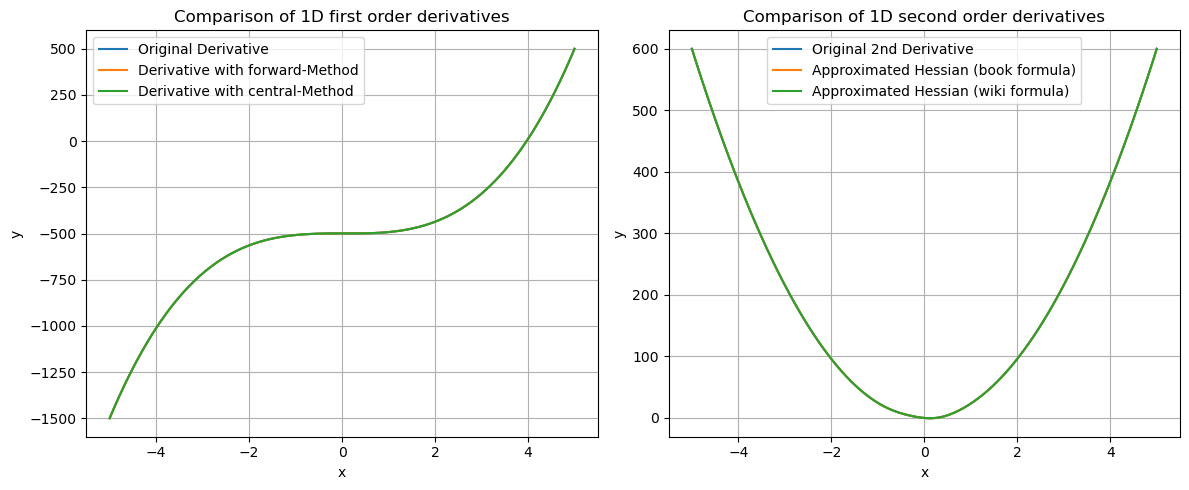

Checking if individual values from the forward-difference method match with the original derivative:
  100.00% of all values approximated by the forward-difference method are close to the original derivative, given accuracy rtol=1.00e-05 & atol=1.00e-08.
Checking if individual values from the central-difference method match with the original derivative:
  100.00% of all values approximated by the central-difference method are close to the original derivative, given accuracy rtol=1.00e-05 & atol=1.00e-08.


Checking if individual values from the hessian approximation (book formula) match with the original hessian:
  41.00% of all values approximated by the hessian approximation (book formula) are close to the original hessian, given accuracy rtol=1.00e-05 & atol=1.00e-08.
Checking if individual values from the hessian approximation (wiki formula) match with the original hessian:
  46.00% of all values approximated by the hessian approximation (wiki formula) are close to the original hes

In [15]:
x = np.linspace(-5, 5, 100)
original_gradient = test_f_prime(x)
original_hessian = test_f_2prime(x)

gradient_forward = np.zeros(x.shape[0])
gradient_central = np.zeros(x.shape[0])
approx_hessian_book = np.zeros(x.shape[0])
approx_hessian_wiki = np.zeros(x.shape[0])

for i in range(x.shape[0]):
    gradient_forward[i] = forward_difference(test_f, x[i], epsilon)
    gradient_central[i] = central_difference(test_f, x[i], epsilon)
    approx_hessian_book[i] = hessian_approximation_book(test_f, x[i], epsilon=1e-5)
    approx_hessian_wiki[i] = hessian_approximation_wiki(test_f, x[i], epsilon=1e-5)

# Create a figure and two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the first subplot
axs[0].plot(x, original_gradient, label="Original Derivative")
axs[0].plot(x, gradient_forward, label="Derivative with forward-Method")
axs[0].plot(x, gradient_central, label="Derivative with central-Method")
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title('Comparison of 1D first order derivatives')
axs[0].legend()
axs[0].grid(True)

# Plot the second subplot
axs[1].plot(x, original_hessian, label="Original 2nd Derivative")
axs[1].plot(x, approx_hessian_book, label="Approximated Hessian (book formula)")
axs[1].plot(x, approx_hessian_wiki, label="Approximated Hessian (wiki formula)")
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_title('Comparison of 1D second order derivatives')
axs[1].legend()
axs[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

_ = original_approx_comparison(original_gradient, gradient_forward, "original derivative", "forward-difference method")
_ = original_approx_comparison(original_gradient, gradient_central, "original derivative", "central-difference method")
print("\n")
# Hessian comparison which original tolerance will give not so great results
_ = original_approx_comparison(original_hessian, approx_hessian_book, "original hessian", "hessian approximation (book formula)")
_ = original_approx_comparison(original_hessian, approx_hessian_wiki, "original hessian", "hessian approximation (wiki formula)")
print("\n")
# So run another test with a bit higher tolerance
_ = original_approx_comparison(original_hessian, approx_hessian_book, "original hessian", "hessian approximation (book formula)", rtol=1e-3, atol=1e-6)
_ = original_approx_comparison(original_hessian, approx_hessian_wiki, "original hessian", "hessian approximation (wiki formula)", rtol=1e-3, atol=1e-6)

$\textbf{Printing the Rosenbrock function to see the results:}$

In [17]:
# Testing on some random values to see if the Hessian Approximations make sense
x0 = np.linspace(-5, 5, 100)
x1 = np.linspace(-5, 5, 100)
for _ in range(5):
    i, j = np.random.randint(0, 100), np.random.randint(0, 100)
    x = np.array([x0[i], x1[j]])
    original_hessian_x = h_2prime(x)
    print(f"Original Hessian for h(x) at {x}: \n{original_hessian_x}")
    book_hessian_approx_x = hessian_approximation_book(h, x, 1e-5)
    print(f"Hessian Approxiamtion (Book forumla) for h(x) at {x}: \n{book_hessian_approx_x}")
    wiki_hessian_approx_x = hessian_approximation_wiki(h, x, 1e-5)
    print(f"Hessian Approxiamtion (Wiki forumla) for h(x) at {x}: \n{wiki_hessian_approx_x}")
    print("-"*100)

Original Hessian for h(x) at [ 0.35353535 -3.88888889]: 
[[4537.53703704 -822.91582492]
 [-822.91582492   45.49617386]]
Hessian Approxiamtion (Book forumla) for h(x) at [ 0.35353535 -3.88888889]: 
[[4537.53671081 -822.92729076]
 [-822.92729076   45.49519872]]
Hessian Approxiamtion (Wiki forumla) for h(x) at [ 0.35353535 -3.88888889]: 
[[4537.53841612 -822.91577996]
 [-822.91577996   45.49690402]]
----------------------------------------------------------------------------------------------------
Original Hessian for h(x) at [ 0.55555556 -0.65656566]: 
[[ 129.82353841 -216.85521886]
 [-216.85521886  100.59259259]]
Hessian Approxiamtion (Book forumla) for h(x) at [ 0.55555556 -0.65656566]: 
[[ 129.82368958 -216.85540474]
 [-216.85540474  100.59256539]]
Hessian Approxiamtion (Wiki forumla) for h(x) at [ 0.55555556 -0.65656566]: 
[[ 129.82347641 -216.85520046]
 [-216.85520046  100.59260092]]
---------------------------------------------------------------------------------------------------

In [18]:
# Create a grid of x, y values
x0 = np.linspace(-10, 10, 1000)
x1 = np.linspace(-10, 10, 1000)

# Running a check and comparing all the original values with the approximated gradient values for each method
for i in range(x0.shape[0]):
    x = np.array([x0[i], x1[i]])
    if i == 0:
        # Creating gradients from original
        g_original_gradient = g_prime(x)
        h_original_gradient = h_prime(x)
        
        # Creating gradients via the different approximation methods
        g_forward = forward_difference(g, x, epsilon)
        h_forward = forward_difference(h, x, epsilon)
        g_central = central_difference(g, x, epsilon)
        h_central = central_difference(h, x, epsilon)
        
    else:
        # Adding original gradients together for easier comparison
        g_original_gradient = np.vstack((g_original_gradient, g_prime(x)))
        h_original_gradient = np.vstack((h_original_gradient, h_prime(x)))
        
        # Adding gradients from the different approximation methods together for easier comparison
        g_forward = np.vstack((g_forward, forward_difference(g, x, epsilon)))
        h_forward = np.vstack((h_forward, forward_difference(h, x, epsilon)))
        g_central = np.vstack((g_central, central_difference(g, x, epsilon)))
        h_central = np.vstack((h_central, central_difference(h, x, epsilon)))

print("Checking gradient values for the Rosenbrock function g(x):")
_ = original_approx_comparison(g_original_gradient, g_forward, "original gradient", "forward-difference method")
_ = original_approx_comparison(g_original_gradient, g_central, "original gradient", "central-difference method")
print("\n")
print("Checking values for the other function h(x):")
_ = original_approx_comparison(h_original_gradient, h_forward, "original gradient", "forward-difference method")
_ = original_approx_comparison(h_original_gradient, h_central, "original gradient", "central-difference method")

Checking gradient values for the Rosenbrock function g(x):
Checking if individual values from the forward-difference method match with the original gradient:
  100.00% of all values approximated by the forward-difference method are close to the original gradient, given accuracy rtol=1.00e-05 & atol=1.00e-08.
Checking if individual values from the central-difference method match with the original gradient:
  100.00% of all values approximated by the central-difference method are close to the original gradient, given accuracy rtol=1.00e-05 & atol=1.00e-08.


Checking values for the other function h(x):
Checking if individual values from the forward-difference method match with the original gradient:
  100.00% of all values approximated by the forward-difference method are close to the original gradient, given accuracy rtol=1.00e-05 & atol=1.00e-08.
Checking if individual values from the central-difference method match with the original gradient:
  100.00% of all values approximated by th

In [19]:
# Running a check and comparing all the original values with the approximated hessian values for each method
epsilon_list = [epsilon, central_epsilon, 1e-6, 1e-5, 1e-4, 1e-3]
ranking = []

# Creating hessians from original and adding them together for easier comparison
for i in range(x0.shape[0]):
    x = np.array([x0[i], x1[i]])
    if i == 0:
        g_original_hessian = g_2prime(x)
        h_original_hessian = g_2prime(x)
    else:
        g_original_hessian = np.dstack((g_original_hessian, g_2prime(x)))
        h_original_hessian = np.dstack((h_original_hessian, h_2prime(x)))

# Trying the hessian approximation for different values of epsilon to see what the best value yields the best results
for eps in epsilon_list:
    # Creating hessians from the different approximated methods and adding them together for easier comparison
    for i in range(x0.shape[0]):
        x = np.array([x0[i], x1[i]])
        if i == 0:
            g_hessian_approx_book = hessian_approximation_book(g, x, eps)
            h_hessian_approx_book = hessian_approximation_book(h, x, eps)
            g_hessian_approx_wiki = hessian_approximation_wiki(g, x, eps)
            h_hessian_approx_wiki = hessian_approximation_wiki(h, x, eps)
        else:
            g_hessian_approx_book = np.dstack((g_hessian_approx_book, hessian_approximation_book(g, x, eps)))
            h_hessian_approx_book = np.dstack((h_hessian_approx_book, hessian_approximation_book(h, x, eps)))
            g_hessian_approx_wiki = np.dstack((g_hessian_approx_wiki, hessian_approximation_wiki(g, x, eps)))
            h_hessian_approx_wiki = np.dstack((h_hessian_approx_wiki, hessian_approximation_wiki(h, x, eps)))
    
    print(f"Comparing results for approximation with epsilon = {eps:.2e}\n")
    
    print("Checking values for the Rosenbrock function g(x):")
    res1 = original_approx_comparison(g_original_hessian, g_hessian_approx_book, "original hessian", "hessian approximation method (book)", rtol=1e-3, atol=1e-6)
    res2 = original_approx_comparison(g_original_hessian, g_hessian_approx_wiki, "original hessian", "hessian approximation method (wiki)", rtol=1e-3, atol=1e-6)
    print("\n")
    print("Checking values for the other function h(x):")
    res3 = original_approx_comparison(h_original_hessian, h_hessian_approx_book, "original hessian", "hessian approximation method (book)", rtol=1e-3, atol=1e-6)
    res4 = original_approx_comparison(h_original_hessian, h_hessian_approx_wiki, "original hessian", "hessian approximation method (wiki)", rtol=1e-3, atol=1e-6)
    print("\n" + "=" * 160 + "\n") 
    
    overall_score = np.mean([res1, res2, res3, res4])
    ranking.append((eps, overall_score))
    
ranking = sorted(ranking, key=lambda x: x[1], reverse=True)
print("Best two values for epsilon (based on this test) are:")
print(f"  epsilon = {ranking[0][0]:.2e} with an overall score of {ranking[0][1]:.2f}%.")
print(f"  epsilon = {ranking[1][0]:.2e} with an overall score of {ranking[1][1]:.2f}%.")

Comparing results for approximation with epsilon = 1.05e-08

Checking values for the Rosenbrock function g(x):
Checking if individual values from the hessian approximation method (book) match with the original hessian:
  0.88% of all values approximated by the hessian approximation method (book) are close to the original hessian, given accuracy rtol=1.00e-03 & atol=1.00e-06.
Checking if individual values from the hessian approximation method (wiki) match with the original hessian:
  1.57% of all values approximated by the hessian approximation method (wiki) are close to the original hessian, given accuracy rtol=1.00e-03 & atol=1.00e-06.


Checking values for the other function h(x):
Checking if individual values from the hessian approximation method (book) match with the original hessian:
  0.05% of all values approximated by the hessian approximation method (book) are close to the original hessian, given accuracy rtol=1.00e-03 & atol=1.00e-06.
Checking if individual values from the he

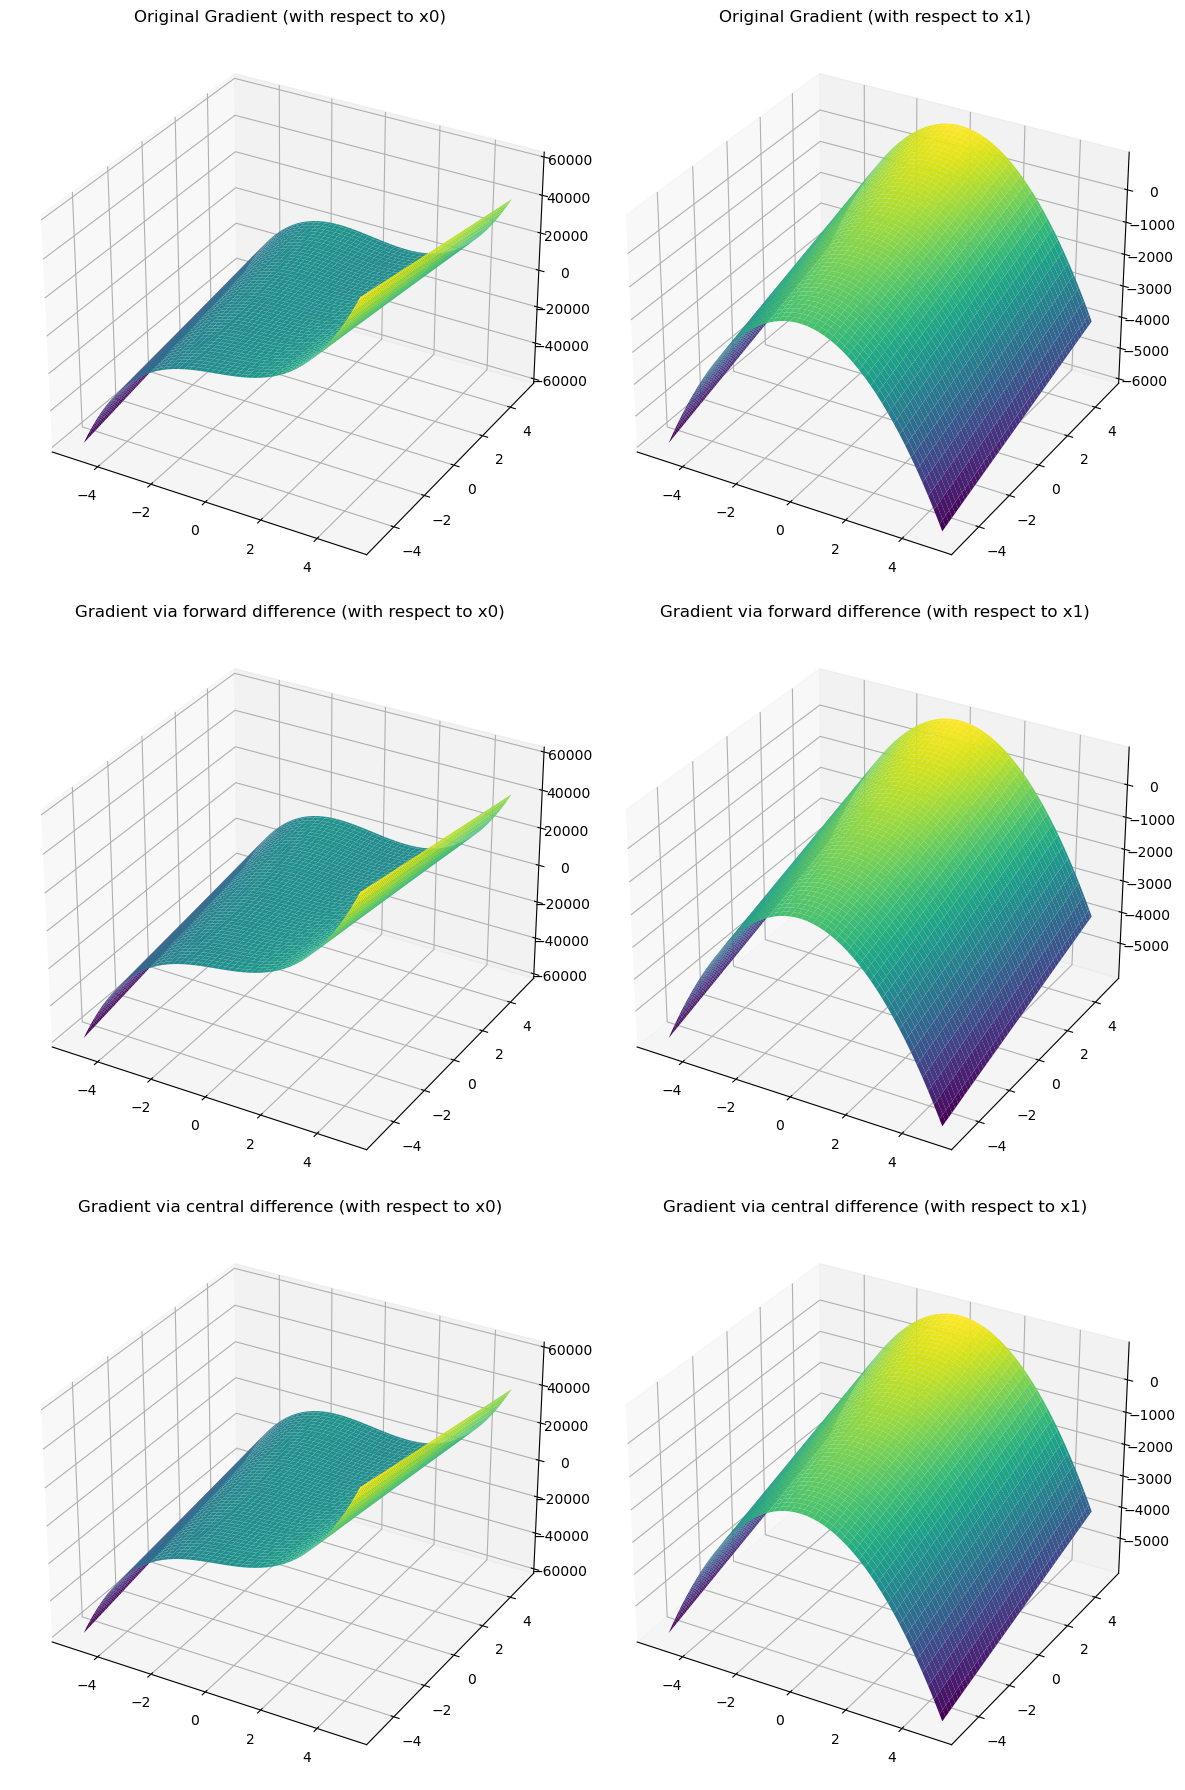

In [20]:
# Create a grid of x, y values
x0 = np.linspace(-5, 5, 100)
x1 = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x0, x1)

# Compute gradients for x0
original_gradient_x0 = np.zeros_like(X)
forward_gradient_x0 = np.zeros_like(X)
central_gradient_x0 = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        x = np.array([X[i, j], Y[i, j]])
        original_gradient_x0[i, j] = g_prime(x)[0]
        forward_gradient_x0[i, j] = forward_difference(g, x, epsilon)[0]
        central_gradient_x0[i, j] = central_difference(g, x, epsilon)[0]


# Compute gradients for x1
original_gradient_x1 = np.zeros_like(X)
forward_gradient_x1 = np.zeros_like(X)
central_gradient_x1 = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        x = np.array([X[i, j], Y[i, j]])
        original_gradient_x1[i, j] = g_prime(x)[1]
        forward_gradient_x1[i, j] = forward_difference(g, x, epsilon)[1]
        central_gradient_x1[i, j] = central_difference(g, x, epsilon)[1]

# Create figure
fig = plt.figure(figsize=(12, 18))

# Plot original gradient for x0
ax1 = fig.add_subplot(3, 2, 1, projection='3d')
ax1.plot_surface(X, Y, original_gradient_x0, cmap='viridis')
ax1.set_title('Original Gradient (with respect to x0)')

# Plot original gradient for x1
ax2 = fig.add_subplot(3, 2, 2, projection='3d')
ax2.plot_surface(X, Y, original_gradient_x1, cmap='viridis')
ax2.set_title('Original Gradient (with respect to x1)')

# Plot forward gradient for x0
ax3 = fig.add_subplot(3, 2, 3, projection='3d')
ax3.plot_surface(X, Y, forward_gradient_x0, cmap='viridis')
ax3.set_title('Gradient via forward difference (with respect to x0)')

# Plot forward gradient for x1
ax4 = fig.add_subplot(3, 2, 4, projection='3d')
ax4.plot_surface(X, Y, forward_gradient_x1, cmap='viridis')
ax4.set_title('Gradient via forward difference (with respect to x1)')

# Plot central gradient for x0
ax5 = fig.add_subplot(3, 2, 5, projection='3d')
ax5.plot_surface(X, Y, central_gradient_x0, cmap='viridis')
ax5.set_title('Gradient via central difference (with respect to x0)')

# Plot central gradient for x1
ax6 = fig.add_subplot(3, 2, 6, projection='3d')
ax6.plot_surface(X, Y, central_gradient_x1, cmap='viridis')
ax6.set_title('Gradient via central difference (with respect to x1)')

plt.tight_layout()
plt.show()